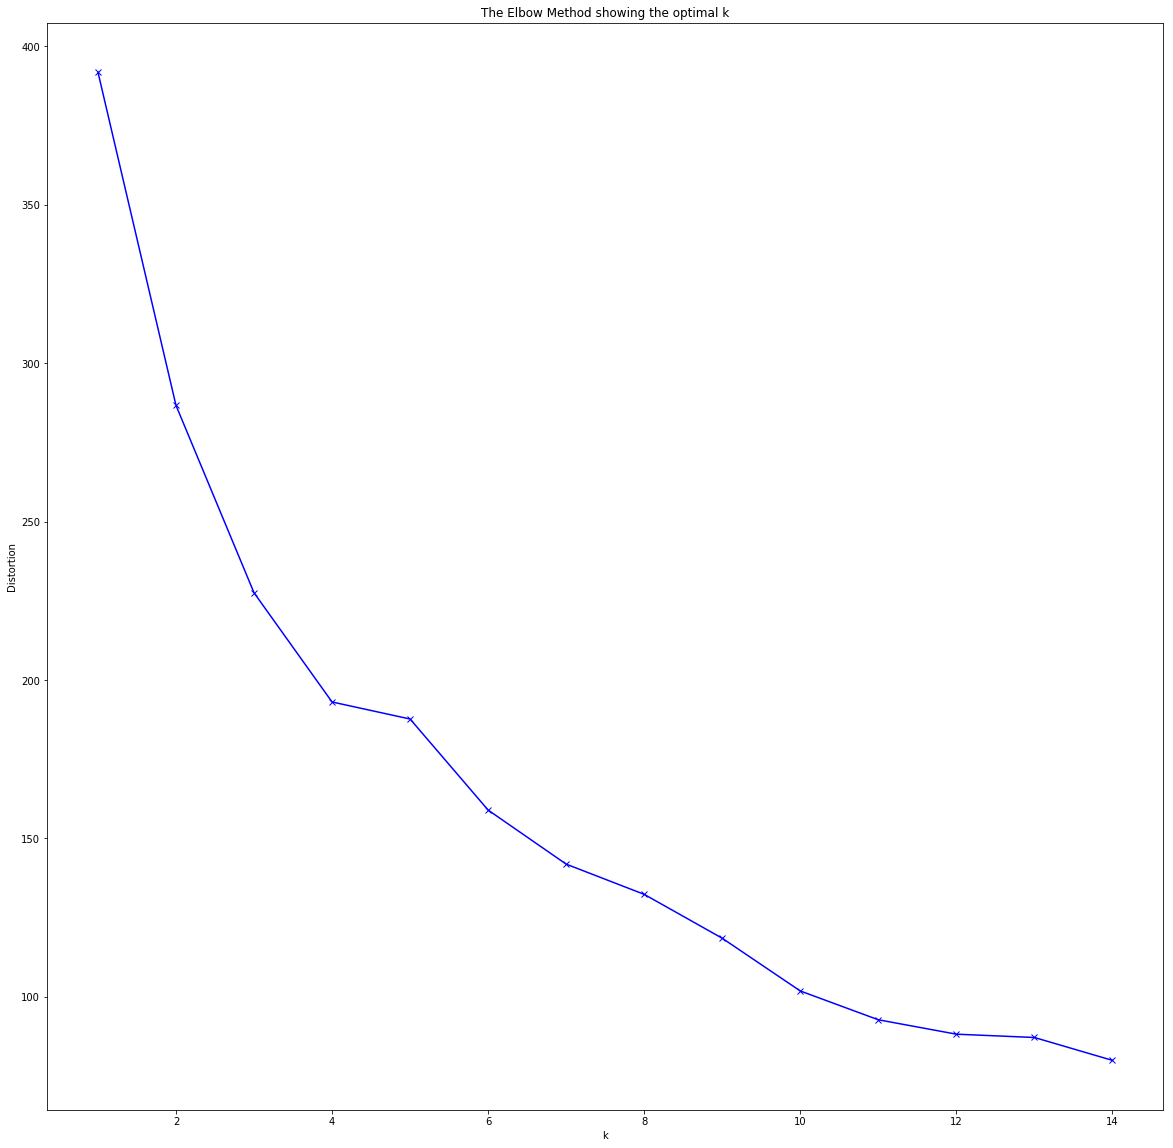

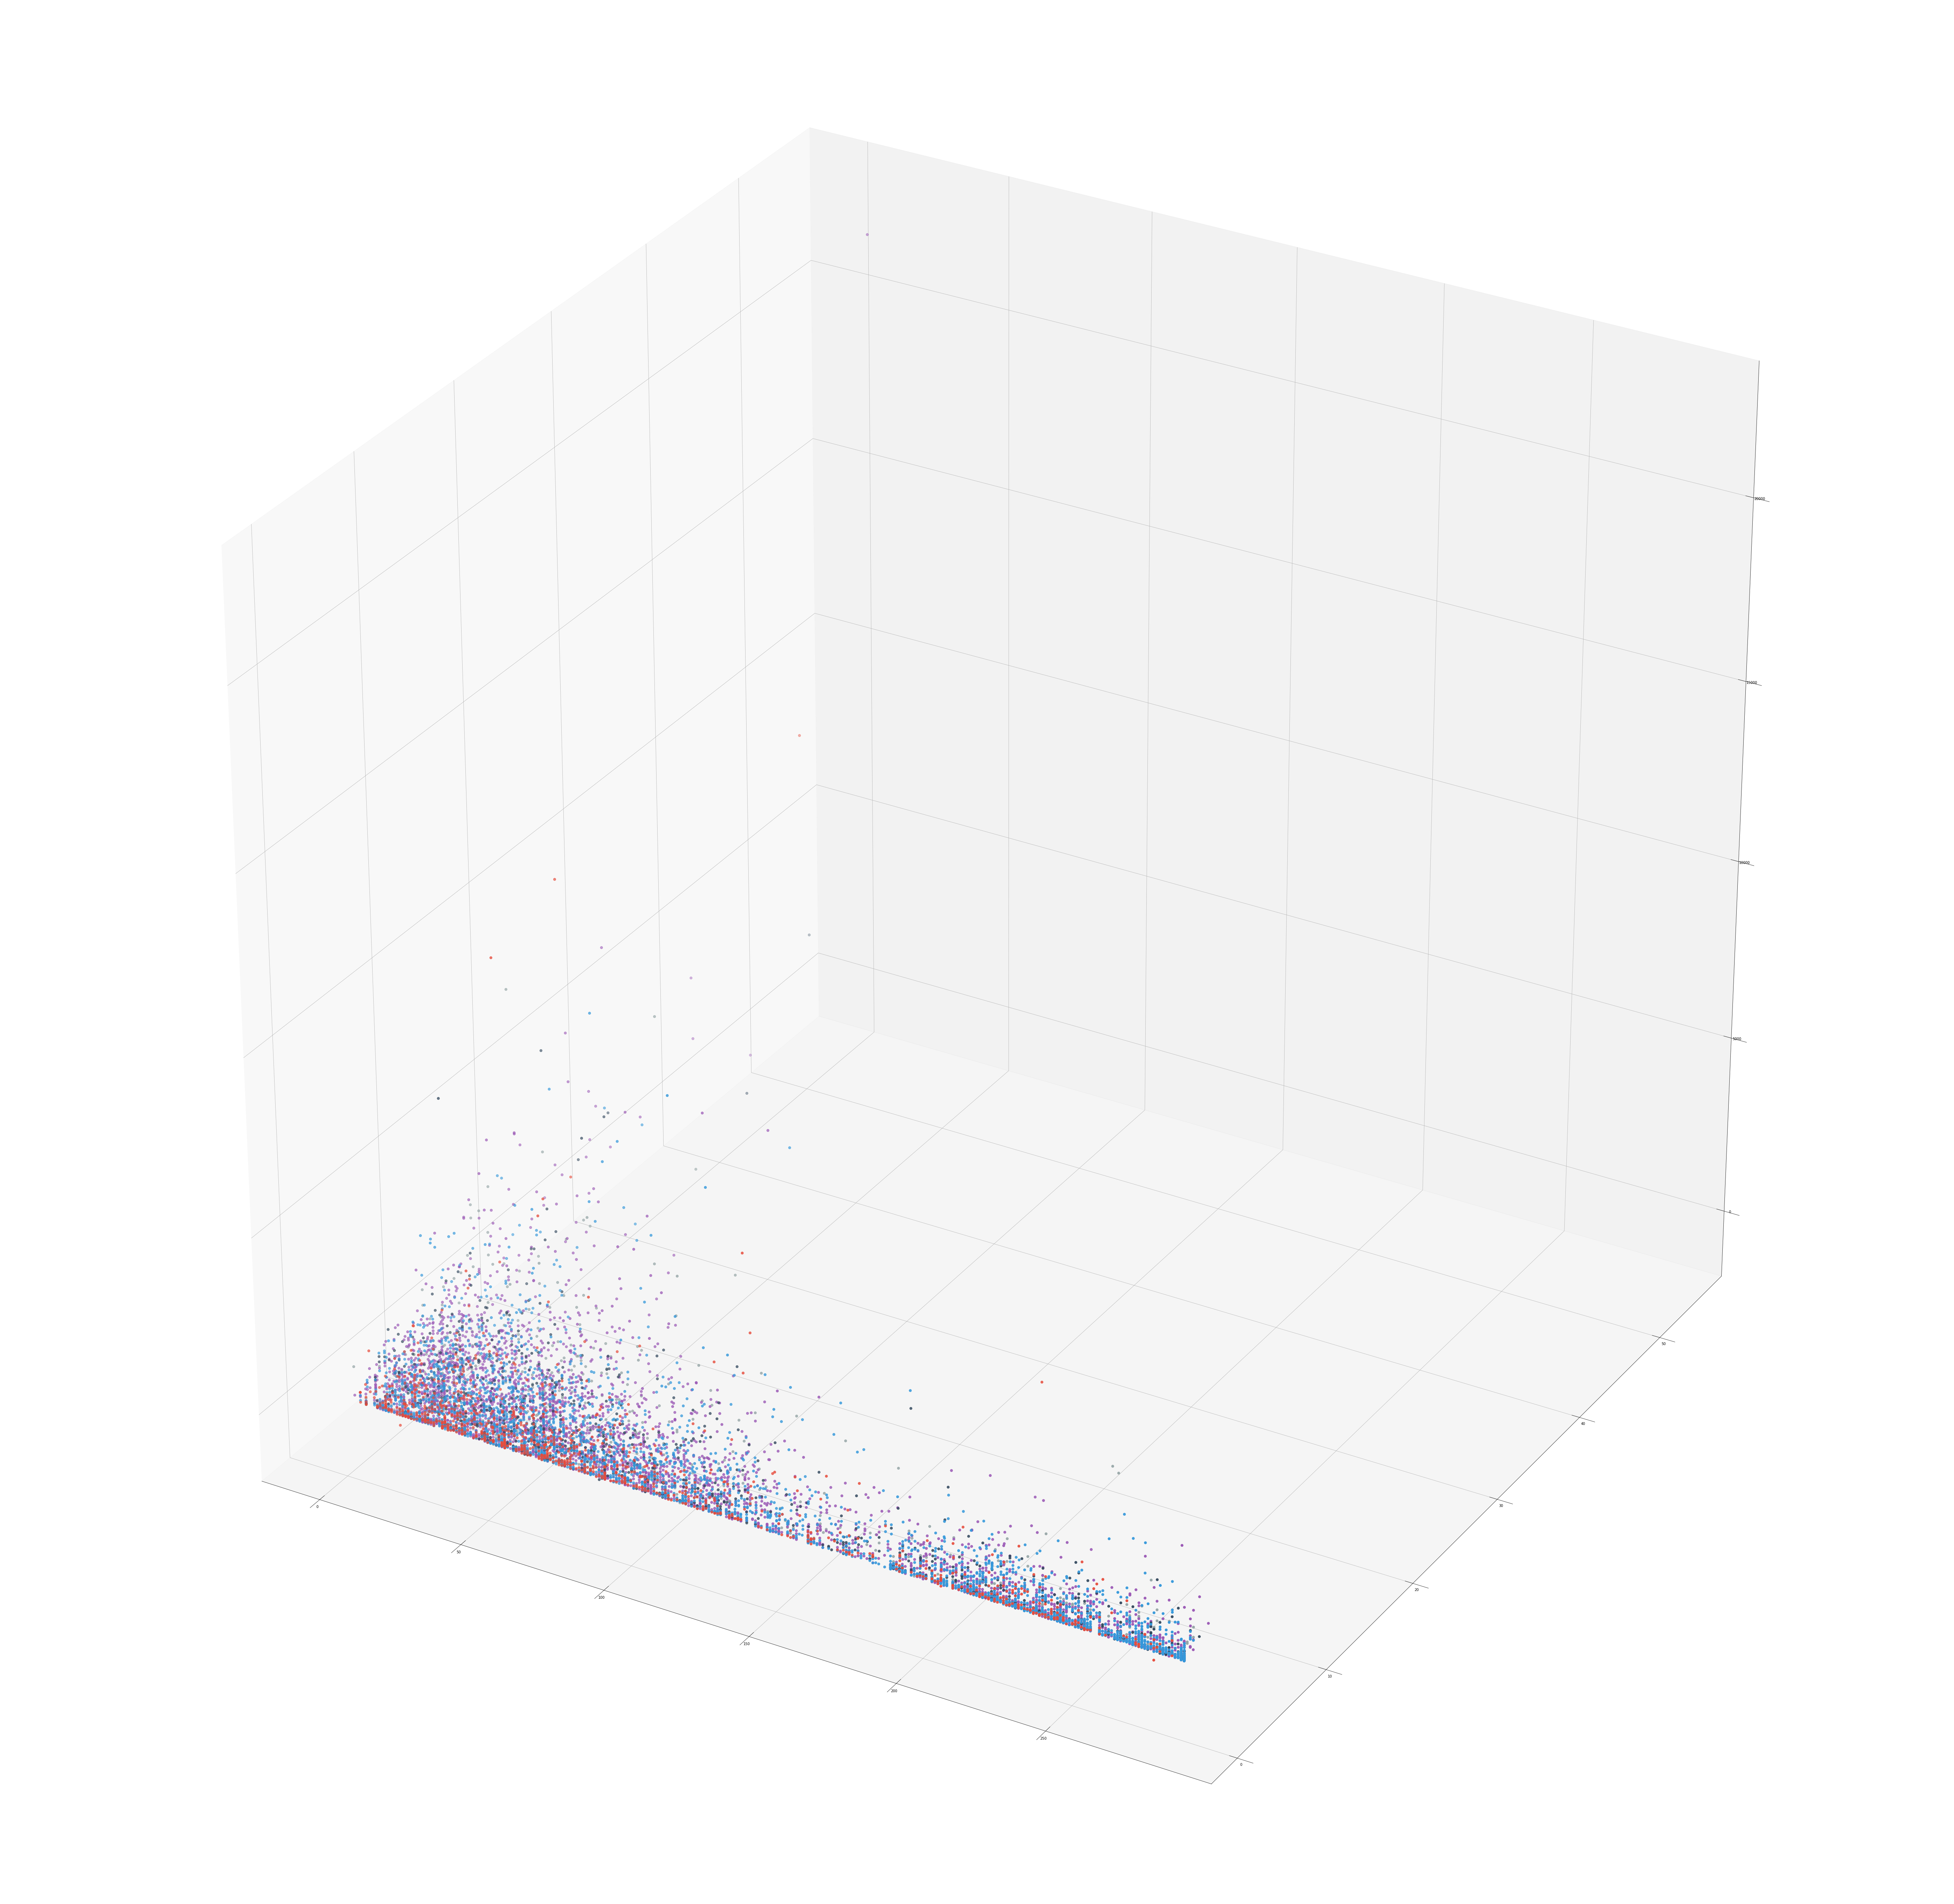

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from datetime import datetime
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import sklearn.metrics as sm
from mpl_toolkits.mplot3d import Axes3D
color = sns.color_palette()


# Read data
basket_table=pd.read_csv("C:\\Users\\MOCCA\\Desktop\\lekakosData\\data\\basket.csv", sep=';')
customer_table=pd.read_csv("C:\\Users\\MOCCA\\Desktop\\lekakosData\\data\\customer.csv", sep=';')
class_table=pd.read_csv("C:\\Users\\MOCCA\\Desktop\\lekakosData\\data\\class.csv", sep=';')
document_table=pd.read_csv("C:\\Users\\MOCCA\\Desktop\\lekakosData\\data\\Document.csv", sep=';')
# basket_table.head(10)
# customer_table
# class_table.head(10)
# document_table.head(10)

#Change date column to datetime object
document_table['Document DATETIME'] = document_table['Document date'].astype(str)
document_table['Document DATETIME'] = document_table['Document DATETIME'].str[0:4] + '-' + document_table['Document DATETIME'].str[4:6] + '-' + document_table['Document DATETIME'].str[6:]
document_table
document_table['Document DATETIME'] = pd.to_datetime(document_table['Document DATETIME'])
document_table['Document date']
document_table['Document DATETIME']


# Rename Document n# to Document n. so it matches basket table
document_table = document_table.rename(columns={'Document n#': 'Document n.'})

# Find quantities of items
quantity_of_each_SKU = basket_table.groupby(['Document n.','SKU','Class','Item value']).size().reset_index(name='Quantity')
quantity_of_each_SKU

# Merge quantity table with class table to get description of item
document_num_merged_with_class = pd.merge(quantity_of_each_SKU,class_table,how='left',on='Class')
document_num_merged_with_class = document_num_merged_with_class.drop('Class', axis=1)
document_num_merged_with_class

# Group by the document table to get unique document numbers so we can merge it later
document_table_unique = document_table.groupby(['Document n.','Customer code','Document date','Document DATETIME']).size().reset_index(name='Count')
document_table_unique = document_table_unique.drop('Count', axis=1)
document_table_unique

# Merge document and class table with document table to get City column later
document_and_class_merged_with_CID = pd.merge(document_num_merged_with_class,document_table_unique,how='left',on='Document n.')
document_and_class_merged_with_CID

# Merge document,class and customer code table with customer table to get City
document_class_CID_merged_with_City = pd.merge(document_and_class_merged_with_CID,customer_table,how='left',on='Customer code')
document_class_CID_merged_with_City = document_class_CID_merged_with_City.drop(['Post code','Day of birth','Month of birth','Year of birth'], axis=1)
document_class_CID_merged_with_City

# Find Total Price (= Quantity x Item value)
document_class_CID_merged_with_City['Total_Price'] = document_class_CID_merged_with_City['Quantity']*document_class_CID_merged_with_City['Item value']
document_class_CID_merged_with_City

# Now we will build the quantified RFM table

# We start from monetary column
monetary_table = document_class_CID_merged_with_City.groupby(['Customer code'])['Total_Price'].aggregate("sum").reset_index()
monetary_table

# Lets continue with frequency column

# We will take city wise count of distinct document number for each customer
customer_frequency_table_b4_count = document_class_CID_merged_with_City[['City','Document n.','Customer code','Document date']].drop_duplicates()
customer_frequency_table_b4_count

# Calculating the count of unique purchase for each customer
frequency_table = customer_frequency_table_b4_count.groupby(["City","Customer code"])["Document n."].aggregate("count").reset_index()
frequency_table.sort_values(by='Document n.', ascending=False, inplace=True)
frequency_table
frequency_table = frequency_table.rename(columns={'Document n.': 'Frequency'})
frequency_table

# Now the recency column
# First of all, find last date of purchases and convert it to datetime
last_day = document_class_CID_merged_with_City['Document DATETIME'].max()
last_day


# We initialize the recency_table by droping duplicates of Customer code and Document date from main table
recency_table_b4_count = document_class_CID_merged_with_City[['Customer code','Document date','Document DATETIME']].drop_duplicates()
# # document_class_CID_merged_with_City

# We now will find the last day of purchases from every customer
recency_table = recency_table_b4_count.groupby(["Customer code"])["Document DATETIME"].aggregate("max").reset_index()
recency_table_b4_count
recency_table

# Calculating the count of unique last day for each customer
# recency_table = recency_table_b4_count.groupby(['Customer code', 'Document date','Document DATETIME'])['Document DATETIME'].aggregate("max").reset_index()
# recency_table.sort_values(by='Document date', ascending=False, inplace=True)

# Calculate Days until last bought from the last day of our dataset
recency_table['Days'] = last_day - recency_table['Document DATETIME']
recency_table.drop('Document DATETIME', axis=1, inplace=True)
recency_table

# Now lets merge the 3 tables (recency,frequency,monetary) on Customer code
frequency_monetary_table = pd.merge(monetary_table,frequency_table, how='left', on='Customer code')
frequency_monetary_table
quantified_rfm_table = pd.merge(frequency_monetary_table, recency_table, how='left', on='Customer code')
quantified_rfm_table.drop('City', axis=1, inplace=True)
quantified_rfm_table

# To use K-means we should change timedelta64 type to float (so it can match the rest of the columns)
quantified_rfm_table['Days'] = quantified_rfm_table['Days'].astype(str)
quantified_rfm_table['Days'] = quantified_rfm_table['Days'].str[0:3].str.strip().str.replace('d', '')
quantified_rfm_table['Days'] = quantified_rfm_table['Days'].astype(float)
quantified_rfm_table

# Change Total_price column to float
quantified_rfm_table['Total_Price'] = quantified_rfm_table['Total_Price'].astype(float)
quantified_rfm_table['Total_Price']
quantified_rfm_table

# Change Customer code column to float
quantified_rfm_table['Customer code'] = quantified_rfm_table['Customer code'].astype(float) 
quantified_rfm_table = quantified_rfm_table[np.isfinite(quantified_rfm_table['Frequency'])]
quantified_rfm_table

# KMeans modeling
model = KMeans(n_clusters=5)
model.fit(quantified_rfm_table)
model.labels_

# The Elbow Method showing the optimal k

X = np.array(list(zip(quantified_rfm_table['Days'], quantified_rfm_table['Frequency'], quantified_rfm_table['Total_Price']))).reshape(len(quantified_rfm_table['Days']), 3)
 
# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.figure(figsize=(20,20))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Plot KMeans --------COLORS , "#e74c3c", "#34495e", "#2ecc71"
fig = plt.figure(figsize=(100,100))
ax = fig.add_subplot(111, projection = '3d')

colormap = np.array(["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"])

ax.scatter(quantified_rfm_table['Days'], quantified_rfm_table['Frequency'], quantified_rfm_table['Total_Price'], s=50, c=colormap[model.labels_], depthshade=True)
plt.show()